In [2]:
import numpy as np
import pandas as pd
import random
import tqdm
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns 
import yaml
from pathlib import Path
import sys 
import os 
sys.path.append(os.path.dirname(os.getcwd()))
from util.functions import logistic
from structure_generation.path_connection_gen import ProceduralGraphGenerator, StatsUtils, GraphStructureGenerator




In [3]:
geometric_graph_conf = yaml.safe_load(Path('config.yml').read_text())['reachability']

In [4]:
geometric_graph_conf

{'num_simulation_runs': 30,
 'mean_degrees': [5],
 'nodes': 100,
 'structure_names': ['random_geometric', 'barabasi_albert']}

In [52]:
import multiprocessing, itertools
from typing import Union, Optional, Tuple, List
import networkx as nx 

from utils import run_single_simulation, run_simulation, plot_results

## REVERSABLE GEOMETRIC GRAPH SIMULATION

In [9]:
graph_name = "random_geometric"
for degree in geometric_graph_conf['mean_degrees']: 
    print(f"simulation run for mean degree {degree}")
    simulation_run = run_simulation(degree, graph_name)

simulation run for mean degree 5


100%|██████████| 30/30 [00:11<00:00,  2.56it/s]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average num nodes 98.83333333333333 std :  6.272072136773371


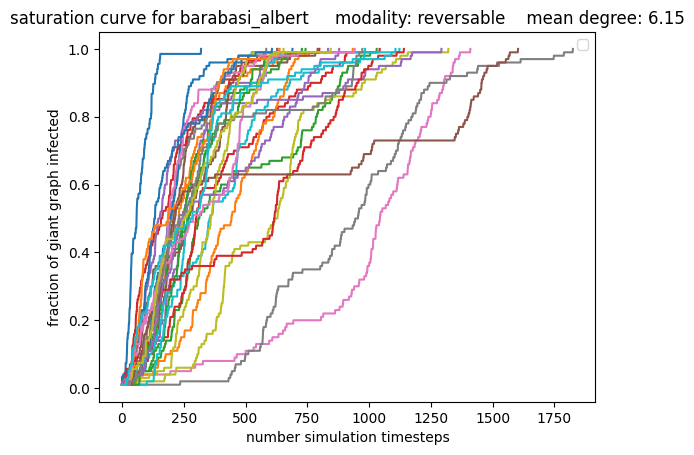

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average num nodes 98.83333333333333 std :  6.272072136773371


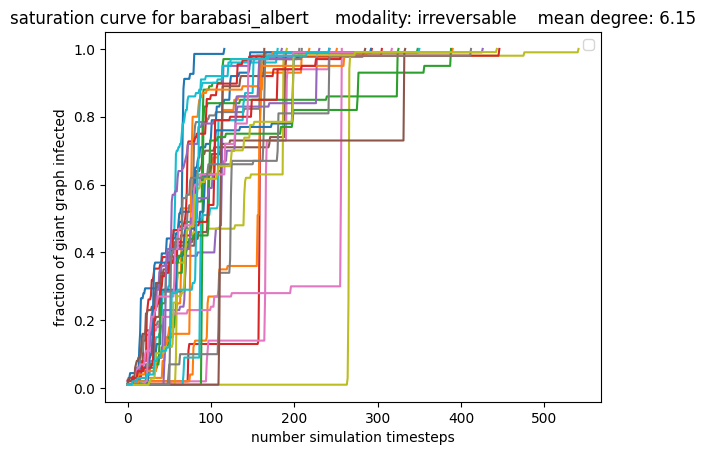

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average num nodes 98.83333333333333 std :  6.272072136773371


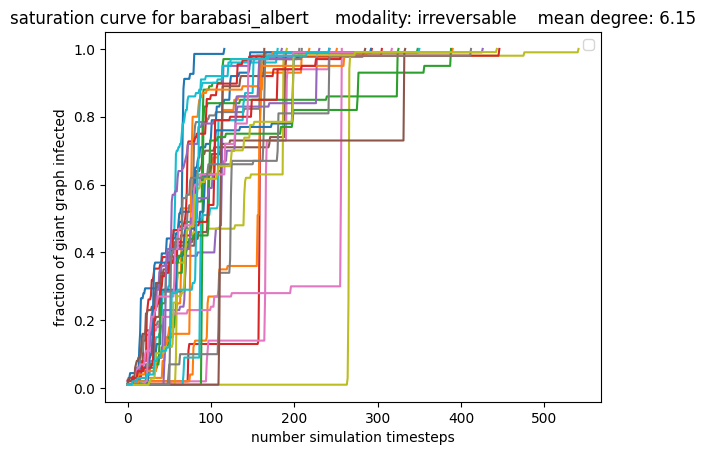

In [51]:
for mode in simulation_run: 
    plot_results(mode, graph_name)
    #print(mode)

Text(5.069444444444445, 0.5, 'count density')

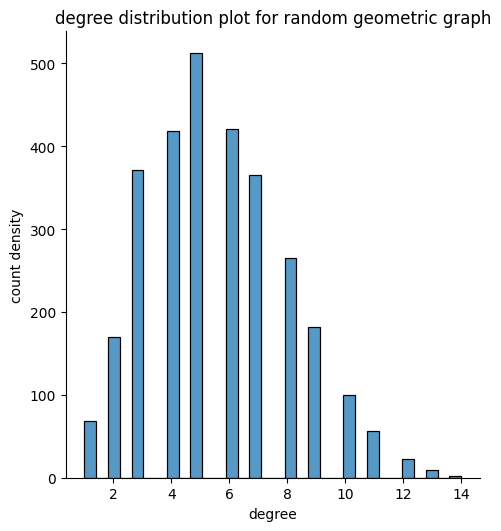

In [12]:
#Degree distribution for the random geometric

degrees_list = []
for run in simulation_run[0]['info_dict']:
    degrees_list.extend(run['degree_list'])

sns.displot(degrees_list)
plt.title("degree distribution plot for random geometric graph")
plt.xlabel("degree")
plt.ylabel("count density")

IRREVERSABLE GEOMETRIC GRAPH SIMULATION

In [13]:
graph_name = "barabasi_albert"
for degree in geometric_graph_conf['mean_degrees']: 
    print(f"simulation run for mean degree {degree}")
    simulation_run_barbassi = run_simulation(degree, graph_name)

simulation run for mean degree 5


100%|██████████| 30/30 [00:04<00:00,  6.60it/s]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average num nodes 100.0 std :  0.0


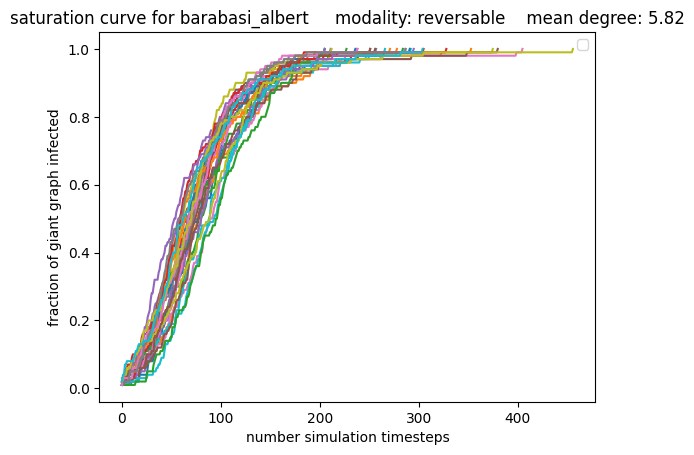

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average num nodes 100.0 std :  0.0


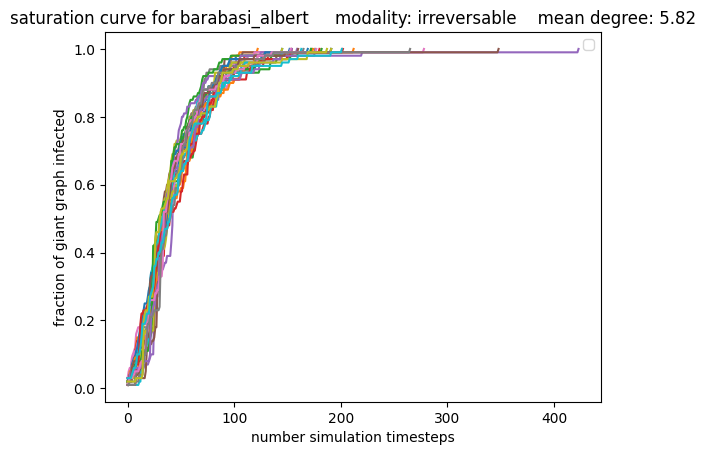

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average num nodes 100.0 std :  0.0


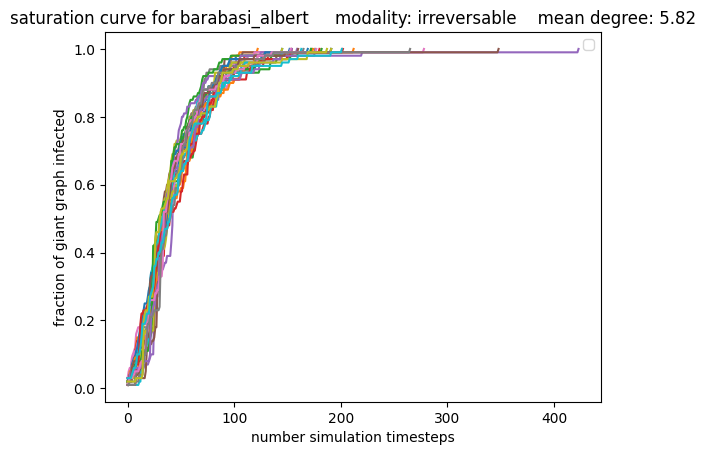

In [53]:
for mode in simulation_run_barbassi: 
    plot_results(mode, graph_name)

Text(-3.6805555555555554, 0.5, 'count density')

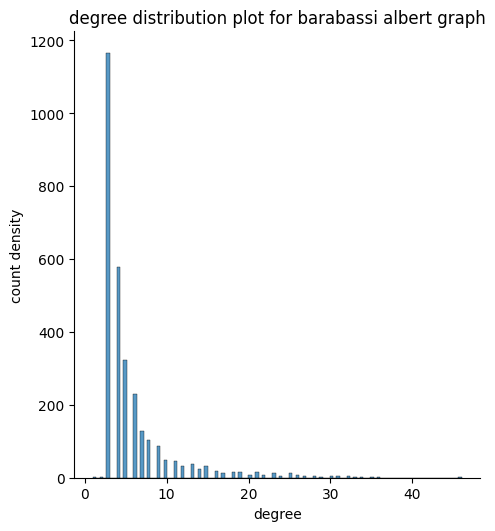

In [54]:
#Degree distribution for the barabassi albert 
degrees_list = []
for run in simulation_run_barbassi[0]['info_dict']:
    degrees_list.extend(run['degree_list'])

sns.displot(degrees_list)
plt.title("degree distribution plot for barabassi albert graph")
plt.xlabel("degree")
plt.ylabel("count density")

Results for reversable albert simulation 